In [46]:

import glob
import os

import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math

from neuroformer.model_neuroformer import GPT, GPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils_2 import (set_seed, update_object, 
                                 check_common_attrs, running_jupyter, 
                                 all_device, load_config, update_config, 
                                 dict_to_object, object_to_dict, recursive_print)
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import make_intervals, round_n, SpikeTimeVidData2
import gdown

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

import argparse
from neuroformer.SpikeVidUtils import round_n

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

def parse_args():
    parser = argparse.ArgumentParser()
    # parser.add_argument("--infer", action="store_true", help="Inference mode")
    parser.add_argument("--train", action="store_true", default=False, help="Train mode")
    parser.add_argument("--dist", action="store_true", default=False, help="Distributed mode")
    parser.add_argument("--seed", type=int, default=25, help="Random seed")
    parser.add_argument("--resume", type=str, default=None, help="Resume from checkpoint")
    parser.add_argument("--rand_perm", action="store_true", default=False, help="Randomly permute the ID column")
    parser.add_argument("--mconf", type=str, default=None, help="Path to model config file")
    parser.add_argument("--eos_loss", action="store_true", default=False, help="Use EOS loss")
    parser.add_argument("--no_eos_dt", action="store_true", default=False, help="No EOS dt token")
    parser.add_argument("--downstream", action="store_true", default=False, help="Downstream task")
    parser.add_argument("--freeze_model", action="store_true", default=False, help="Freeze model")
    parser.add_argument("--title", type=str, default=None)
    parser.add_argument("--dataset", type=str, default="Distance-Coding")
    parser.add_argument("--behavior", action="store_true", default=False, help="Behavior task")
    parser.add_argument("--pred_behavior", action="store_true", default=False, help="Predict behavior")
    parser.add_argument("--past_state", action="store_true", default=False, help="Input past state")
    parser.add_argument("--visual", action="store_true", default=False, help="Visualize")
    parser.add_argument("--contrastive", action="store_true", default=False, help="Contrastive")
    parser.add_argument("--clip_loss", action="store_true", default=False, help="Clip loss")
    parser.add_argument("--clip_vars", nargs="+", default=['id','frames'], help="Clip variables")
    parser.add_argument("--class_weights", action="store_true", default=False, help="Class weights")
    parser.add_argument("--resample", action="store_true", default=False, help="Resample")
    parser.add_argument("--loss_bprop", type=str, default=None, help="Loss type to backpropagate")
    parser.add_argument("--config", type=str, default=None, help="Config file")
    return parser.parse_args()

if running_jupyter(): # or __name__ == "__main__":
    print("Running in Jupyter")
    INFERENCE = False
    DIST = False
    SEED = 69
    DOWNSTREAM = False
    TITLE = None
    RESUME = None
    RAND_PERM = False
    MCONF = None
    EOS_LOSS = False
    NO_EOS_DT = False
    FREEZE_MODEL = False
    TITLE = None
    DATASET = "medial"
    BEHAVIOR = False
    PREDICT_BEHAVIOR = False
    VISUAL = True
    PAST_STATE = True
    CONTRASTIVE = False
    CLIP_LOSS = True
    CLIP_VARS = ['id','frames']
    CLASS_WEIGHTS = False
    RESAMPLE_DATA = False
    LOSS_BPROP = None
    CONFIG = None
else:
    print("Running in terminal")
    args = parse_args()
    INFERENCE = not args.train
    DIST = args.dist
    SEED = args.seed
    DOWNSTREAM = args.downstream
    TITLE = args.title
    RESUME = args.resume
    RAND_PERM = args.rand_perm
    MCONF = args.mconf
    EOS_LOSS = args.eos_loss
    NO_EOS_DT = args.no_eos_dt
    FREEZE_MODEL = args.freeze_model
    DATASET = args.dataset
    BEHAVIOR = args.behavior
    PREDICT_BEHAVIOR = args.pred_behavior
    VISUAL = args.visual
    PAST_STATE = args.past_state
    CONTRASTIVE = args.contrastive
    CLIP_LOSS = args.clip_loss
    CLIP_VARS = args.clip_vars
    CLASS_WEIGHTS = args.class_weights
    RESAMPLE_DATA = args.resample
    LOSS_BPROP = args.loss_bprop
    CONFIG = args.config

# SET SEED - VERY IMPORTANT
set_seed(SEED)

print(f"CONTRASTIUVEEEEEEE {CONTRASTIVE}")
print(f"VISUAL: {VISUAL}")
print(f"PAST_STATE: {PAST_STATE}")


os.environ["CUDA_VISIBLE_DEVICES"] = "7"

Running in Jupyter
CONTRASTIUVEEEEEEE False
VISUAL: True
PAST_STATE: True


In [47]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing


"""

from neuroformer.prepare_data import DataLinks
from neuroformer.DataUtils import round_n


if DATASET in ["first", "visnav"]:
    data_path = "./data/VisNav_VR_Expt"
elif DATASET == "medial":
    data_path = "./data/VisNav_VR_Expt/MedialVRDataset/"
elif DATASET == "lateral":
    data_path = "./data/VisNav_VR_Expt/LateralVRDataset"

spikes_path = f"{data_path}/NF_1.5/spikerates_dt_0.01.npy"
speed_path = f"{data_path}/NF_1.5/behavior_speed_dt_0.05.npy"
stim_path = f"{data_path}/NF_1.5/stimulus.npy"

spikes = np.load(spikes_path)
speed = np.round(np.load(speed_path), 3)
stimulus = np.load(stim_path)

frame_feats = None
print(f"spikes: {spikes.shape}, speed: {speed.shape}")

spikes: (1906, 163069), speed: (32614,)


In [48]:
# Use the function
if CONFIG is None:
    # config_path = "./configs/NF_1.5/mconf.yaml"
    # config_path = "./configs/NF_1.5/VisNav_VR_Expt/gru2_only/mconf.yaml"
    # config_path = "./configs/NF_1.5/VisNav_VR_Expt/mlp_only/mconf.yaml"
    # config_path = "./configs/NF_1.5/VisNav_VR_Expt/gru2_only_cls/mconf.yaml"
    config_path = "./configs/NF_1.5/VisNav_VR_Expt/gru_only/mconf.yaml"
else:
    config_path = CONFIG
config = load_config(config_path)  # replace 'config.yaml' with your file path

In [49]:
window = config.window.curr
window_prev = config.window.prev
dt = config.resolution.dt

In [50]:
## resnet3d feats
from neuroformer.DataUtils import split_data_by_interval

intervals = np.arange(0, spikes.shape[1] * config.resolution.dt, config.window.curr)
train_intervals, test_intervals, finetune_intervals = split_data_by_interval(intervals, r_split=0.8, r_split_ft=0.01)
# np.save(f"/share/edc/home/antonis/neuroformer/_rebuttal/behavior/regression/{DATASET}/intervals_speed.npy")

from neuroformer.DataUtils import Tokenizer
# make sure intervals = same size as distance

min_shape = min(intervals.shape[0], speed.shape[0])
intervals = intervals[:min_shape]
distance = speed[:min_shape]

print(f"intervals.shape: {intervals.shape}")
print(f"distance.shape: {distance.shape}")

# -------- #


spikes_dict = {
    "ID": spikes,
    "Frames": stimulus,
    "Interval": intervals,
    "dt": config.resolution.dt,
    "id_block_size": config.block_size.id,
    "prev_id_block_size": config.block_size.prev_id,
    "frame_block_size": config.block_size.frame,
    "window": config.window.curr,
    "window_prev": config.window.prev,
    "frame_window": config.window.frame,
    
}

""" structure:
{
    type_of_modality:
        {name of modality: {'data':data, 'dt': dt, 'predict': True/False},
        ...
        }
    ...
}
"""

def visnav_callback(frames, frame_idx, n_frames):
    if isinstance(frames, np.ndarray):
        frames = torch.from_numpy(frames)
    f_idx_0 = max(0, frame_idx - n_frames)
    f_idx_1 = f_idx_0 + n_frames
    chosen_frames = frames[f_idx_0:f_idx_1].type(torch.float32).unsqueeze(0)
    return chosen_frames


frames = {'feats': stimulus, 'callback': visnav_callback}
modalities = {
    'all': 
            {'speed': 
                {'data': speed, 'dt': config.window.speed, 'predict': True, 'objective': config.predict.speed.objective}
            },
}


max_window = max(config.window.curr, config.window.prev)
dt_range = math.ceil(max_window / dt) + 1
n_dt = [round_n(x, dt) for x in np.arange(0, dt_range, dt)]

token_types = {
    'ID': {'tokens': list(np.arange(0, spikes.shape[0]))},
    'dt': {'tokens': n_dt, 'resolution': dt},
    'speed': {'tokens': sorted(list(set(speed))), 'resolution': 0.2},
}

tokenizer = Tokenizer(token_types, max_window, dt)




intervals.shape: (32614,)
distance.shape: (32614,)
{'tokens': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 20

In [51]:
for modality_type, modality in modalities.items():
    for variable_type, variable in modality.items():
        print(variable_type, variable)




speed {'data': array([ 1.74 ,  1.778,  1.704, ..., -1.107, -1.14 , -1.164], dtype=float32), 'dt': 0.05, 'predict': True, 'objective': 'regression'}


In [52]:
# # %%
# var_group = 'Interval'
# int_trials = df.groupby([var_group, 'Trial']).size()
# print(int_trials.mean())
# # df.groupby(['Interval', 'Trial']).agg(['nunique'])
# n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.1 * n_unique))
# # df.groupby(['Interval_2', 'Trial']).size().mean()




In [53]:
from neuroformer.DataUtils import NFDataloader

train_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=DATASET, 
                             frames=frames, intervals=train_intervals, modalities=modalities)
test_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=DATASET, 
                            frames=frames, intervals=test_intervals, modalities=modalities)
finetune_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=DATASET, 
                                frames=frames, intervals=finetune_intervals, modalities=modalities)

    
# print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')
iterable = iter(train_dataset)
x, y = next(iterable)




Min Interval: 0.3
Intervals:  26091
Window:  0.05
Window Prev:  0.25
Population Size:  1909
ID Population Size:  1909
DT Population Size:  2603
Using explicitly passed intervals
Min Interval: 0.3
Intervals:  14592
Window:  0.05
Window Prev:  0.25
Population Size:  1909
ID Population Size:  1909
DT Population Size:  2603
Using explicitly passed intervals
Min Interval: 0.3
Intervals:  260
Window:  0.05
Window Prev:  0.25
Population Size:  1909
ID Population Size:  1909
DT Population Size:  2603
Using explicitly passed intervals


In [54]:
from neuroformer.utils_2 import update_config, dict_to_object, object_to_dict

# update config
updated_config = update_config(config, modalities, tokenizer, x, y, 2)
updated_dict_object = dict_to_object(updated_config)
config = updated_dict_object



In [55]:
from neuroformer.model_neuroformer_2 import GPT, GPTConfig

config.id_vocab_size = tokenizer.ID_vocab_size
model = GPT(config, tokenizer)

08/14/2023 15:34:09 - INFO - neuroformer.model_neuroformer_2 -   NF_GRU: no. params: 1184256
08/14/2023 15:34:09 - INFO - neuroformer.model_neuroformer_2 -   number of parameters: 2.186240e+07


256 2603


In [56]:
loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)
iterable = iter(loader)
x, y = next(iterable)
# x = all_device(x, 'cuda')
# y = all_device(y, 'cuda')
recursive_print(y)
preds, features, loss = model(x, y)

id torch.Size([32, 100]) torch.int64
dt torch.Size([32, 100]) torch.int64
modalities_speed_value torch.Size([32, 1]) torch.float32
modalities_speed_dt torch.Size([32]) torch.float32


In [57]:
from neuroformer.utils_2 import predict_modality

MAX_EPOCHS = 500
BATCH_SIZE = 32 * 6
SHUFFLE = True

if config.gru_only:
    model_name = "GRU"
elif config.mlp_only:
    model_name = "MLP"
elif hasattr(config, "gru2_only") and config.gru2_only:
    # if config.predict.speed.objective == "regression":
    model_name = "GRU_2.0"
else:
    model_name = "Neuroformer"

CKPT_PATH = f"/share/edc/home/antonis/neuroformer/models/NF.15/Visnav_VR_Expt/{DATASET}/{model_name}/speed_{modalities['all']['speed']['objective']}/{str(config.layers)}/{SEED}"

from neuroformer.trainer import TrainerConfig, Trainer

tconf = TrainerConfig(max_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, learning_rate=7e-5, 
                    num_workers=16, lr_decay=True, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=1.0, shuffle=SHUFFLE,
                    final_tokens=len(train_dataset)*(config.block_size.id) * (MAX_EPOCHS),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    show_grads=False,
                    ckpt_path=CKPT_PATH, no_pbar=False, 
                    dist=DIST, save_every=0, eval_every=5, min_eval_epoch=50)

trainer = Trainer(model, train_dataset, test_dataset, tconf, config)
# trainer.train()


In [63]:
import pickle

if model_name == "Neuroformer":
    CKPT_PATH = f"/share/edc/home/antonis/neuroformer/models/NF.15/Visnav_VR_Expt/{DATASET}/speed_regression/69/"
elif hasattr(config, "gru2_only") and config.gru2_only:
    if config.predict.speed.objective == "classification":
        model_name = "GRU_2.0_cls"

CKPT_PATH = "/share/edc/home/antonis/neuroformer/models/NF.15/Visnav_VR_Expt/GRU/medial/speed_regression/namespace(state_history=8, state=8, stimulus=0, self_att=8, modalities=namespace(n_behavior=25))/69"

# CPKPT_PATH = "/share/edc/home/antonis/neuroformer/models/NF.15/Visnav_VR_Expt/GRU/lateral/speed_regression/namespace(state_history=8, state=8, stimulus=0, self_att=8, modalities=namespace(n_behavior=25))"
# CKPT_PATH = "./models/NF.15/Visnav_VR_Expt/lateral/speed_regression/69/"
model.load_state_dict(torch.load(os.path.join(CKPT_PATH, "_epoch_speed.pt"), map_location=torch.device('cpu')))
# model.load_state_dict(torch.load("./models/NF.15/Visnav_VR_Expt/GRU/lateral/speed_regression/namespace(state_history=8, state=8, stimulus=0, self_att=8, modalities=namespace(n_behavior=25))/69/_epoch_speed.pt", map_location=torch.device('cpu')))
# tokenizer = pickle.load(open(os.path.join(CKPT_PATH, "tokenizer.pkl"), 'rb'))

<All keys matched successfully>

In [64]:
# x, y = next(iterable)
# recursive_print(y)
# preds, features, loss = model(x, y)

# print("Loss: ", loss['speed'])
# print("Preds: ", preds['speed'])
# print("True: ", y['modalities']['speed']['value'])



In [65]:
if DATASET == 'medial':
    interval_path = "/share/edc/home/antonis/neuroformer/_rebuttal/behavior/regression/medial/medial_intervals_speed.npy"
    interval_df = np.load(interval_path, allow_pickle=True)
if DATASET == 'lateral':
    interval_path = "/share/edc/home/antonis/neuroformer/_rebuttal/behavior/regression/lateral/lateral_intervals_speed.npy"
    interval_df = np.load(interval_path, allow_pickle=True)

# n = 7
# length = 300

# interval_df = interval_df[n*length:(n+1)*length]

behavior_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=DATASET, 
                                frames=frames, intervals=interval_df, modalities=modalities)

Min Interval: 0.3
Intervals:  6786
Window:  0.05
Window Prev:  0.25
Population Size:  1909
ID Population Size:  1909
DT Population Size:  2603
Using explicitly passed intervals


In [66]:
from neuroformer.utils_2 import predict_modality


modality = 'speed'
objective = modalities['all'][modality]['objective']
behavior_preds = predict_modality(model, behavior_dataset, modality=modality, 
                                  block_type='modalities', objective=objective)

# # save predictions
behavior_preds.rename(columns={'modalities_speed_value': 'behavior',
                               'interval': 'Interval'}, inplace=True)
behavior_preds.to_csv(f"{CKPT_PATH}/behavior_preds.csv")

100%|██████████| 1697/1697 [12:08<00:00,  2.33it/s]


/tmp/ipykernel_1367683/3440963802.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='red')
/tmp/ipykernel_1367683/3440963802.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='red')


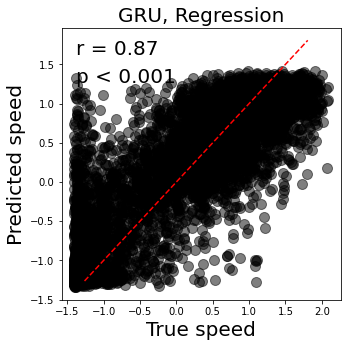

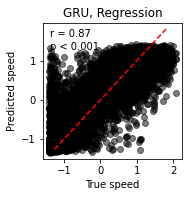

In [67]:
from scipy.stats import pearsonr
from neuroformer.visualize import set_plot_params
from neuroformer.visualize import set_research_params

# set_research_params()

save_path = f"./_rebuttal/behavior/regression/{DATASET}/{model_name}"
if not os.path.exists(save_path):
    os.makedirs(save_path)
behavior_preds.to_csv(os.path.join(save_path, 'behavior_preds.csv'), index=False)

x_true, y_true = behavior_preds['cum_interval'], behavior_preds['true']
x_pred, y_pred = behavior_preds['cum_interval'], behavior_preds['behavior']

# pearson r
r, p = pearsonr([float(y) for y in y_pred], [float(y) for y in y_true])

# plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_true, y_pred, s=100, c='k', alpha=0.5)

# get the current axis limits after plotting your data
xlims = ax.get_xlim()
ylims = ax.get_ylim()
s_f = 0.8
# the line of perfect prediction should span the minimum to the maximum of the current x and y limits
combined_limits = [min(xlims[0], ylims[0]) * s_f, max(xlims[1], ylims[1]) * s_f]
ax.plot(combined_limits, combined_limits, 'k--', color='red')

ax.set_xlabel('True speed', fontsize=20)
ax.set_ylabel('Predicted speed', fontsize=20)
ax.set_title(f'{model_name}, Regression', fontsize=20)
# add pearson r to figure
ax.text(0.05, 0.9, 'r = {:.2f}'.format(r), fontsize=20, transform=ax.transAxes)
# add p to figure
ax.text(0.05, 0.8, 'p < 0.001'.format(p), fontsize=20, transform=ax.transAxes)

# axis limits = [-1.5, 1.5]
# ax.set_xlim(axis_limits)
# ax.set_ylim(axis_limits)
plt.savefig(os.path.join(save_path, 'regression_2.pdf'), dpi=300, bbox_inches='tight')


# plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.scatter(y_true, y_pred, c='k', alpha=0.5)

# get the current axis limits after plotting your data
xlims = ax.get_xlim()
ylims = ax.get_ylim()
s_f = 0.8
# the line of perfect prediction should span the minimum to the maximum of the current x and y limits
combined_limits = [min(xlims[0], ylims[0]) * s_f, max(xlims[1], ylims[1]) * s_f]
ax.plot(combined_limits, combined_limits, 'k--', color='red')

ax.set_xlabel('True speed',)
ax.set_ylabel('Predicted speed',)
ax.set_title(f'{model_name}, Regression',)
# add pearson r to figure
ax.text(0.05, 0.9, 'r = {:.2f}'.format(r), transform=ax.transAxes)
# add p to figure
ax.text(0.05, 0.8, 'p < 0.001'.format(p), transform=ax.transAxes)

# axis limits = [-1.5, 1.5]
# ax.set_xlim(axis_limits)
# ax.set_ylim(axis_limits)
plt.savefig(os.path.join(save_path, 'regression_2.pdf'), dpi=300, bbox_inches='tight')


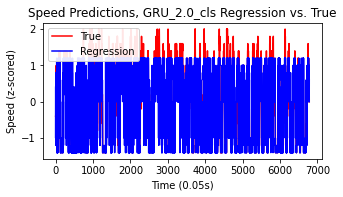

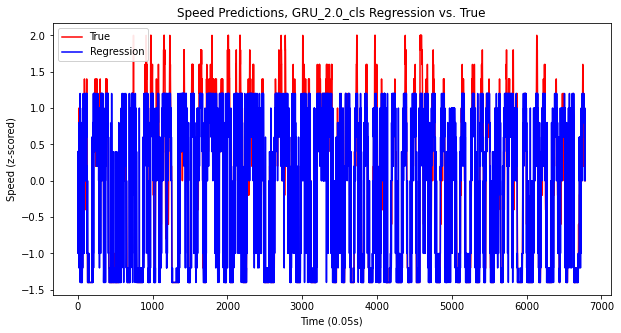

In [18]:
plt.figure(figsize=(5, 2.5))
x = np.arange(len(behavior_preds))
plt.title(f'Speed Predictions, {model_name} Regression vs. True')
plt.plot(x, y_true, c='r', label='True')
plt.plot(x, y_pred, c='b', label='Regression')
plt.xlabel('Time (0.05s)')
plt.ylabel('Speed (z-scored)')
plt.legend(loc='upper left', framealpha=0.9)
plt.savefig(os.path.join(save_path, 'speed_preds.pdf'), bbox_inches='tight')


plt.figure(figsize=(10, 5))
x = np.arange(len(behavior_preds))
plt.title(f'Speed Predictions, {model_name} Regression vs. True')
plt.plot(x, y_true, c='r', label='True')
plt.plot(x, y_pred, c='b', label='Regression')
plt.xlabel('Time (0.05s)')
plt.ylabel('Speed (z-scored)')
plt.legend(loc='upper left', framealpha=0.9)
plt.savefig(os.path.join(save_path, 'speed_preds_2.pdf'), bbox_inches='tight')